# A close up on the domain edge

Romain is setting up an analogon to Haukes EUREC4A simulations for the ORCHESTRA campaign. He is having problems with pressure artifacts near the boundary. This plot shows a closeup of that area. It is also a good example of how my output can be plotted via matplotlibs `matplotlib.pyplot.tripcolor` and provides a somewhat universal function to do so. Of course - once again - this is based on work of [Tobi Kölling](https://easy.gems.dkrz.de/Processing/playing_with_triangles/tripcolor.html). Esentially we:

- Load the data
- Add a grid (keeping all the grids variables)
- *optionally* cut out an area of interest
- read out the cell vertices (grid variable `'vertex_of_cell'`)
- pass it to `ax_triangles` function

Suprisingly this is not horribly slow, even when plotting the entire domain. 

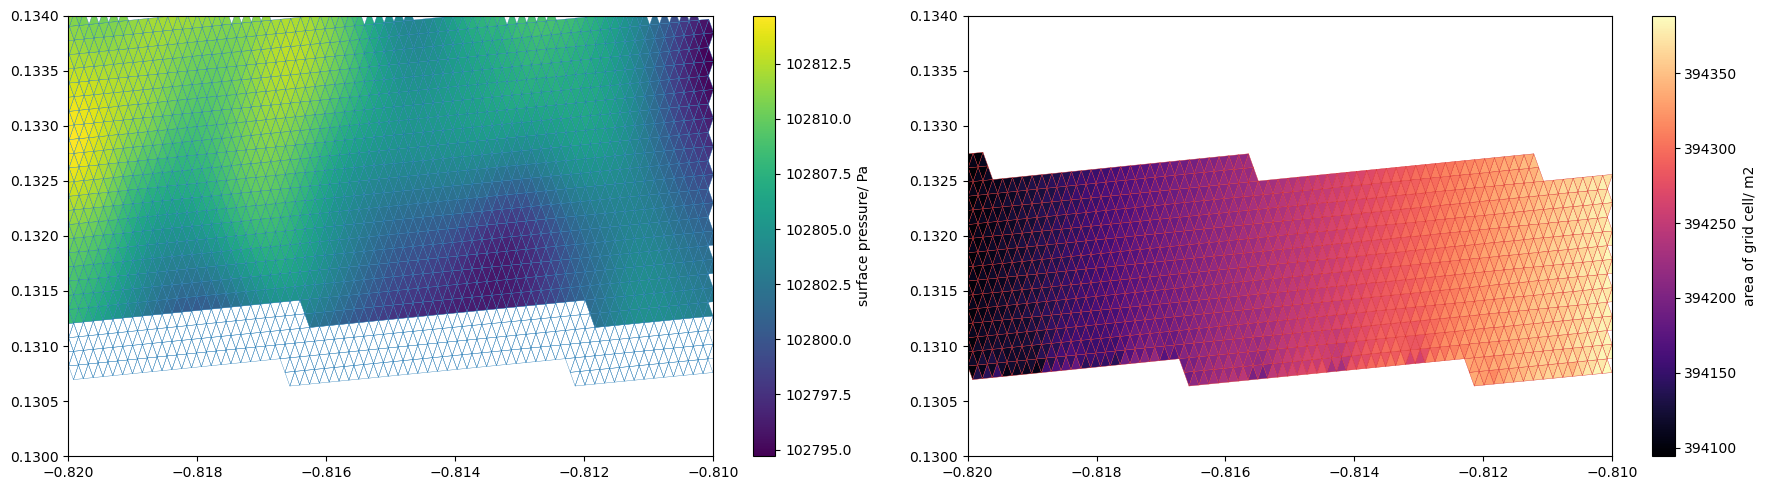

In [1]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import postprocessing as pp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def ax_triangles(ax, dataset, var, cell_vertex_varname='vertex_of_cell', vminmax=(None, None), 
                 cmap='viridis', edgecolor=None, set_xy_lim=False):    
    """
    Plot triangular mesh on a given Axes object.

    This function plots a triangular mesh on a given Axes object using the matplotlib.tripcolor method. The triangular
    mesh is defined by the vertices of cells provided in the dataset. Optionally, a variable can be mapped onto the mesh
    using a colormap.

    Args:
        ax (matplotlib.axes.Axes): The Axes object onto which the triangular mesh will be plotted.
        dataset (xarray.Dataset): The dataset containing the mesh information.
        var (str or None): The name of the variable to be mapped onto the mesh. If None, only the mesh will be plotted
            without coloring.
        cell_vertex_varname (str, optional): The name of the variable in the dataset containing the vertex indices of
            cells. Defaults to 'vertex_of_cell'.
        vminmax (tuple, optional): A tuple containing the minimum and maximum values for the color scale. Defaults to
            (None, None), which means that the color scale is automatically determined based on the data.
        cmap (str or Colormap, optional): The colormap to be used for coloring the mesh. Defaults to 'viridis'.
        edgecolor (str or None, optional): The color of the edges of the triangles. If None, no edges will be drawn.
            Defaults to None.
        set_xy_lim (bool, optional): Whether to automatically set the x and y limits of the Axes object to fit the
            mesh. Defaults to False.

    Returns:
        matplotlib.axes.Axes: The Axes object with the triangular mesh plotted.

    Note:
        - Shoutout to Tobias Kölling, who showcased this here:https://easy.gems.dkrz.de/Processing/playing_with_triangles/tripcolor.html.
        - The vertices of cells should be provided in the dataset as a variable with dimensions
            (number_of_vertices, number_of_cells).
        - If var is not None, the variable specified by var will be mapped onto the mesh using the given colormap.
        - If set_xy_lim is True, the x and y limits of the Axes object will be automatically adjusted to fit the mesh.
    """
    vertices_of_cells = dataset['vertex_of_cell'].T.values - 1
    vmin, vmax = vminmax
    if var == None: 
        nan_field = np.full(len(vertices_of_cells), np.nan)
        trip = ax.tripcolor(dataset.vlon, dataset.vlat, 
                            vertices_of_cells, 
                            nan_field, 
                            vmin=vmin, vmax=vmax, 
                            edgecolors=edgecolor)
    else:
        z_field = dataset[var].values
        trip = ax.tripcolor(dataset.vlon, dataset.vlat, 
                            vertices_of_cells, z_field,   
                            vmin=vmin, vmax=vmax, 
                            edgecolors=edgecolor, 
                            cmap=cmap)
        try:    label = f'{dataset[var].attrs["long_name"]}/ {dataset[var].attrs["units"]}'
        except: label = None
        plt.colorbar(trip, ax=ax, label=label)
    if set_xy_lim:
        used_vertices = np.unique(vertices_of_cells) 
        lat_min = dataset.vlat[used_vertices].min().values
        lat_max = dataset.vlat[used_vertices].max().values
        lon_min = dataset.vlon[used_vertices].min().values
        lon_max = dataset.vlon[used_vertices].max().values
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
    return ax

def load_data(timestep=0):
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_13/moist_adiabatic_13_DOM01_surface_20200109T100000Z.nc'
    data = xr.open_dataset(path)
    data = pp.clean_surface_data(data)
    data = pp.add_grid(data, clean=False, drop_vars=False, rad2deg=False)
    return data.isel(time=timestep)

def load_grid():
    return xr.open_dataset('/work/mh1126/m300872/unchanged/latbc/lateral_boundary_DOM01.grid.nc')

def cut_out(dataset, limits):
    # not used anymore, but i had to adjust my cutout function
    mask = (
          (dataset['clat'].values > limits['lat'][0])
        & (dataset['clat'].values < limits['lat'][1])
        & (dataset['clon'].values > limits['lon'][0])
        & (dataset['clon'].values < limits['lon'][1])
    )
    return dataset.isel({'cell':mask})

def ax_southern_edge(ax, ds, limits, var, cmap='viridis', edgecolor='tab:blue'):
    rectangle = pp.rectangle(limits)
    ds = pp.cut_rectangle(ds, rectangle, varnames={'latitude':'clat', 'longitude':'clon', 'cell':'cell'})
    ax = ax_triangles(ax, ds, var, cmap=cmap, edgecolor=edgecolor, set_xy_lim=True)
    return ax

def fixedfig_pres_south_edge():
    fig, ax = plt.subplots(figsize=(20, 10))
    ds = load_data()
    var = 'pres_sfc'
    limits = {'lat':(0.130, 0.134), 'lon':(-0.820, -0.810)}
    ax = ax_southern_edge(ax, ds, limits, var)
    return fig, ax
    
def fixedfig_latbcgrid_south_edge():
    fig, ax = plt.subplots(figsize=(20, 10))
    ds = load_grid()
    var = 'cell_area'
    cmap = 'magma'
    edgecolor = 'tab:red'
    limits = {'lat':(0.130, 0.134), 'lon':(-0.820, -0.810)}
    ax = ax_southern_edge(ax, ds, limits, var, cmap, edgecolor)
    return fig, ax

def fixedfig_south_edge_combined():
    fig, axs = plt.subplots(1,2, figsize=(18, 5))
    ax = axs[0]
    ds = load_data()
    var = 'pres_sfc'
    limits = {'lat':(0.130, 0.134), 'lon':(-0.820, -0.810)}
    ax = ax_southern_edge(ax, ds, limits, var)
    ax = axs[1]
    ds = load_grid()
    var = 'cell_area'
    cmap = 'magma'
    edgecolor = 'tab:red'
    limits = {'lat':(0.130, 0.134), 'lon':(-0.820, -0.810)}
    ax = ax_southern_edge(ax, ds, limits, var, cmap, edgecolor)
    for ax in axs:
        ax.set_xlim(*limits['lon'])
        ax.set_ylim(*limits['lat'])
    return fig, axs

# fig, ax = fixedfig_pres_south_edge()
# fig, ax = fixedfig_latbcgrid_south_edge()
fig, axs = fixedfig_south_edge_combined()
fig.tight_layout()
fig.show()

(executed in 7s)

In [2]:
def load_data(timestep=0):
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_13/moist_adiabatic_13_DOM01_surface_20200109T150000Z.nc'
    data = xr.open_dataset(path)
    data = pp.clean_surface_data(data)
    data = pp.add_grid(data, clean=False, drop_vars=False, rad2deg=False)
    return data.isel(time=timestep)

def fixedfig_pres_south_edge():
    fig, ax = plt.subplots(figsize=(20, 10))
    ds = load_data()
    var = 'tot_prec'
    cmap = 'viridis'
    ax = ax_triangles(ax, ds, var, vminmax=(0,25),
                      edgecolor='none',
                      cmap=cmap, set_xy_lim=True)
    return fig, ax

fig, ax = fixedfig_pres_south_edge()
fig.show()

(executed in 30s)